# Lesson 3 Assignment
# Houda Aynaou

## Workplace Scenario
A superstore wants to identify customer groupings that visit their stores based on customer transaction (sales) data. These groupings are used for targeted promotions. You are asked to perform customer segmentation on the provided data.


## To do: 
1. Read dataset
2. Calculate the Recency, Frequency, Monitory for each customer
3. Using K-means algorithm, perform customer segmentation
4. Describe your results

In [1]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 500)

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

## 1. Read dataset

In [2]:
LINK = 'https://raw.githubusercontent.com/houdaaynaou/DS-Certificate-UW/master/Course%203%20Machine%20Learning%20Techniques/Data/SuperstoreTransaction.csv'
data = pd.read_csv(LINK, index_col='Row ID')
data.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Row ID,,,,,,,,,,,,,,,,,,,,
1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
data.dtypes

Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

In [4]:
data.shape

(9994, 20)

## 2. Calculate the Recency, Frequency, Monitory for each customer

Given the `Order date` we can calculate : 
* **recency**: the last order date
* **frequency**: how often do they made an order in the last month (or any given window you choose)
* **monetary**: the amount of money spent in the last month

In [5]:
# convert 'Order Date' into Datetime:

data['Order Date'] = pd.to_datetime(data['Order Date'], format = '%m/%d/%Y')
data['Ship Date'] = pd.to_datetime(data['Order Date'], format = '%m/%d/%Y')
data.head()


,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Row ID,,,,,,,,,,,,,,,,,,,,
1,CA-2016-152156,2016-11-08,2016-11-08,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
2,CA-2016-152156,2016-11-08,2016-11-08,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,CA-2016-138688,2016-06-12,2016-06-12,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
4,US-2015-108966,2015-10-11,2015-10-11,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,US-2015-108966,2015-10-11,2015-10-11,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [6]:
roll_sum = data.groupby('Customer ID').rolling(window = '7D', on = 'Order Date')['Sales'].sum()
roll_cnt = data.groupby('Customer ID').rolling(window = '7D', on = 'Order Date')['Quantity'].sum()
roll_min = data.groupby('Customer ID')['Order Date'].diff(periods = 1)

In [7]:
# Gather the features into one DataFrame
data_roll = pd.concat([roll_sum, roll_cnt], axis =1)
data_roll.columns = ['dollar_roll_sum_7D', 'quantity_roll_sum_7D']
data_roll = data_roll.reset_index()
data_roll['last_order_ndays'] = roll_min.fillna(pd.Timedelta('100 days'))
data_roll.head()

,Customer ID,Order Date,dollar_roll_sum_7D,quantity_roll_sum_7D,last_order_ndays
0,AA-10315,2017-06-29,362.940,3.0,NaT
1,AA-10315,2017-06-29,374.480,5.0,100 days
2,AA-10315,2015-10-04,401.440,7.0,0 days
3,AA-10315,2014-03-31,1075.008,9.0,100 days
4,AA-10315,2014-03-31,1127.988,11.0,100 days


### 3. Using K-means algorithm, perform customer segmentation

### 3.1 Normalizing numerical columns

In [8]:
# get categorical colums
cols = data.columns
cat = []
num = []
for col in cols:
    if data[col].dtype == 'O':
        cat.append(col)
    elif data[col].dtype != 'O' and data[col].dtype != '<M8[ns]' :
        num.append(col)


In [9]:
# Standarizing numerical columns
df_num = data[num]
df_num.head()

,Postal Code,Sales,Quantity,Discount,Profit
Row ID,,,,,
1,42420,261.9600,2,0.00,41.9136
2,42420,731.9400,3,0.00,219.5820
3,90036,14.6200,2,0.00,6.8714
4,33311,957.5775,5,0.45,-383.0310
5,33311,22.3680,2,0.20,2.5164


In [10]:
# dropping 'Postal code' column since it's categorical

df_num_cleaned = df_num.drop('Postal Code', axis= 1)
df_num_cleaned.head()

,Sales,Quantity,Discount,Profit
Row ID,,,,
1,261.9600,2,0.00,41.9136
2,731.9400,3,0.00,219.5820
3,14.6200,2,0.00,6.8714
4,957.5775,5,0.45,-383.0310
5,22.3680,2,0.20,2.5164


In [11]:
# normalize features
num_standarized = StandardScaler().fit_transform(df_num_cleaned)
num_features = pd.DataFrame(num_standarized, columns= df_num_cleaned.columns)
num_features.head()

,Sales,Quantity,Discount,Profit
0,0.051510,-0.804303,-0.756643,0.056593
1,0.805633,-0.354865,-0.756643,0.815054
2,-0.345368,-0.804303,-0.756643,-0.093002
3,1.167688,0.544012,1.423149,-1.757484
4,-0.332935,-0.804303,0.212153,-0.111593



### 3.2. Encoding categorical variables with low cardinality:

In [12]:
# dataframe categorical 
df_cat = data[cat]

# Dropping ID's and customer ID to prevent data leakage and Country since it's a constant 
df_cat_cleaned = df_cat.drop(['Order ID', 'Customer ID', 'Product ID','Customer Name', 'Country'], axis =1 )

# Adding 'Postal Code' to the categorical variables
df_cat_cleaned['Postal Code'] = data['Postal Code']

df_cat_cleaned.head()


,Ship Mode,Segment,City,State,Region,Category,Sub-Category,Product Name,Postal Code
Row ID,,,,,,,,,
1,Second Class,Consumer,Henderson,Kentucky,South,Furniture,Bookcases,Bush Somerset Collection Bookcase,42420
2,Second Class,Consumer,Henderson,Kentucky,South,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",42420
3,Second Class,Corporate,Los Angeles,California,West,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,90036
4,Standard Class,Consumer,Fort Lauderdale,Florida,South,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,33311
5,Standard Class,Consumer,Fort Lauderdale,Florida,South,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,33311


In [13]:
# ship, Segment, Region, Category

# # high :City, postal code, Sub-Category, Product Name
# df_cat_cleaned['Product Name'].nunique()

In [14]:
# hotencode protocol_type
enc1 = OneHotEncoder(handle_unknown='ignore',  sparse=False)
encoded_ship_mode= enc1.fit_transform(df_cat_cleaned['Ship Mode'].values.reshape(-1,1))
enc_ship = pd.DataFrame(encoded_ship_mode)

# hotencode serive 
enc2 = OneHotEncoder(handle_unknown='ignore',  sparse=False)
enc_segment = enc2.fit_transform(df_cat_cleaned['Segment'].values.reshape(-1,1))
enc_s = pd.DataFrame(enc_segment)

# hotencode serive 
enc3 = OneHotEncoder(handle_unknown='ignore',  sparse=False)
enc_region = enc3.fit_transform(df_cat_cleaned['Region'].values.reshape(-1,1))
enc_r = pd.DataFrame(enc_region)

# hotencode serive 
enc4 = OneHotEncoder(handle_unknown='ignore',  sparse=False)
enc_category = enc3.fit_transform(df_cat_cleaned['Category'].values.reshape(-1,1))
enc_cat = pd.DataFrame(enc_category)

# dropping column 
X = pd.concat([num_features,enc_ship, enc_s,enc_r, enc_cat], axis=1)
X.head()

,Sales,Quantity,Discount,Profit,0,1,2,3,0,1,2,0,1,2,3,0,1,2
0,0.051510,-0.804303,-0.756643,0.056593,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.805633,-0.354865,-0.756643,0.815054,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.345368,-0.804303,-0.756643,-0.093002,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.167688,0.544012,1.423149,-1.757484,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-0.332935,-0.804303,0.212153,-0.111593,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### 3.3 Applying K means :
#### Applying Kmeans clustering using the Elbow Method:
To determine the number of optimal cluseters, we use the **Elbow Method** which consists of calculating the Within Cluster Sum of Squared Errors (WSS) for different values of k, and choose the k for which WSS first starts to diminish. In the plot of WSS-versus k, this is visible as an elbow.


The steps can be summarized in the below steps:
- Compute K-Means clustering for different values of K by varying K from 1 to 10 clusters.
- For each K, calculate the total within-cluster sum of square (WCSS).
- Plot the curve of WCSS vs the number of clusters K.
- The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters.


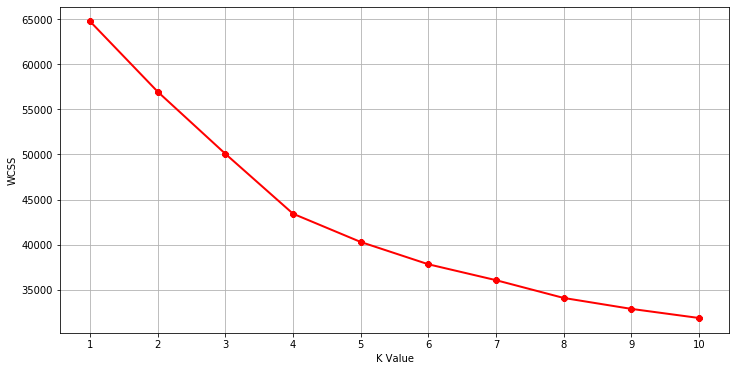

In [15]:
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

The optimal K value is found to be 4 using the elbow method.

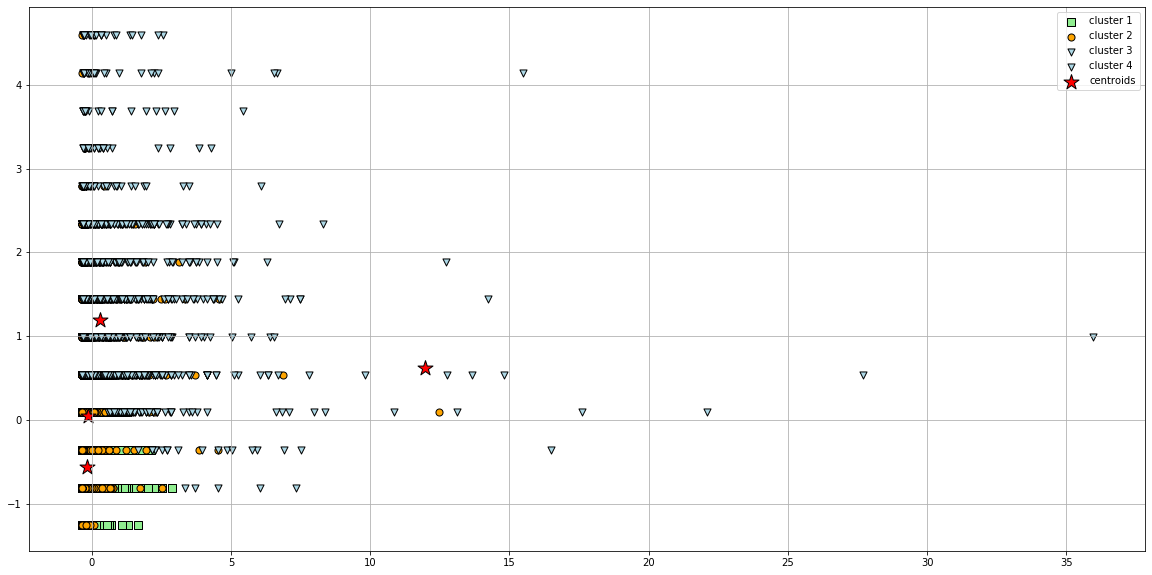

In [16]:
from mpl_toolkits.mplot3d import Axes3D


km = KMeans(n_clusters=4)
clusters = km.fit_predict(X)

# plotting the 5 clusters

plt.figure(figsize=(20,10))
plt.scatter(
    X.values[clusters == 0, 0], X.values[clusters == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X.values[clusters ==  1, 0], X.values[clusters == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X.values[clusters ==  2, 0], X.values[clusters ==  2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

plt.scatter(
    X.values[clusters ==  3, 0], X.values[clusters ==  3, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 4'
)


# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

## 4. Describe your results

There are sevral ways for feature engineering, 2 were applied in this exercise: 

* many numeric to many numeric: extract principal components from a set of features / RFM

Driven by three dimensions (Recency, Frequency, Monetary), RFM is a simple yet powerful method for segmenting customers used often in machine learning models. The reasoning behind RFM is intuitive and consistent across most scenarios: a customer who bought something withing a certain time frame(week or month) is more likely to make another purchase than a customer who has not bought anything in a year. In addition, spendy customers who frequently make purchases are also categorized as valuable using the RFM technique.


* many numeric to one categorical:  k-means clustering 

One of the major application of K means clustering is segmentation of customers. K means is applied to solving clustering tasks to get an idea of the structure of the dataset by grouping data points into distinct non-overlapping subgroups. This gives a better understanding of customers which in turn could be used to increase the revenue of the company.